# Task 3: Sequence-to-Sequence Modeling
- Giulia Luongo 10076102
- Mohammad Sukri 10062921
- Samer Sakor 10074501

In [27]:
# Import core data manipulation libraries
import pandas as pd

# Import PyTorch for deep learning
import torch
from torch.utils.data import Dataset, DataLoader

# Import model and tokenizer from HuggingFace Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Import data splitting utility
from sklearn.model_selection import train_test_split

# For training visualization
import matplotlib.pyplot as plt

# For progress bars
from tqdm import tqdm


In [19]:
# Load dataset
df = pd.read_csv("topical_chat_pairs.csv", delimiter="\t")

# Add <SOS> and <EOS> tokens to the beginning and end of each answer
# These help the model learn where generation starts and ends
df["answer"] = df["answer"].apply(lambda x: "<SOS> " + x.strip() + " <EOS>")

# Split the dataset:
# - 80% training
# - 10% validation
# - 10% testing
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the sizes of each split
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 143800, Val size: 17975, Test size: 17975


In [20]:
# Load the pretrained T5 tokenizer
# This tokenizer will convert text to input IDs and attention masks suitable for the T5 model
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Define a helper function to tokenize a batch of message-answer pairs
def tokenize_batch(df, max_input_length=64, max_output_length=64):
    # Tokenize the input messages
    inputs = tokenizer.batch_encode_plus(
        df["message"].tolist(),              # List of input texts
        max_length=max_input_length,         # Max token length for input
        truncation=True,                     # Truncate inputs that exceed max length
        padding="max_length",                # Pad inputs to the max length
        return_tensors="pt"                  # Return as PyTorch tensors
    )

    # Tokenize the output answers
    targets = tokenizer.batch_encode_plus(
        df["answer"].tolist(),               # List of output texts
        max_length=max_output_length,        # Max token length for output
        truncation=True,                     # Truncate outputs that exceed max length
        padding="max_length",                # Pad outputs to the max length
        return_tensors="pt"                  # Return as PyTorch tensors
    )

    return inputs, targets  # Return the tokenized inputs and targets as dicts


In [21]:
# Define a custom PyTorch Dataset to wrap the tokenized input and target data
class ChatDataset(Dataset):
    def __init__(self, input_encodings, target_encodings):
        # Store the tokenized input and target sequences
        self.input_encodings = input_encodings
        self.target_encodings = target_encodings

    def __len__(self):
        # Return the number of examples in the dataset
        return len(self.input_encodings["input_ids"])

    def __getitem__(self, idx):
        # Return a single training example (as a dictionary of tensors)
        item = {
            "input_ids": self.input_encodings["input_ids"][idx],             # Tokenized input sequence
            "attention_mask": self.input_encodings["attention_mask"][idx],   # Mask to avoid attending to padding
            "labels": self.target_encodings["input_ids"][idx],               # Tokenized target sequence
        }

        # Set padding tokens in labels to -100 so they're ignored by the loss function
        item["labels"][item["labels"] == tokenizer.pad_token_id] = -100
        return item


In [22]:
# Tokenize each dataset split using the helper function
train_inputs, train_targets = tokenize_batch(train_df)
val_inputs, val_targets = tokenize_batch(val_df)
test_inputs, test_targets = tokenize_batch(test_df)

# Wrap each tokenized split into a PyTorch Dataset
# This allows us to iterate over batches of data during training
train_dataset = ChatDataset(train_inputs, train_targets)
val_dataset = ChatDataset(val_inputs, val_targets)
test_dataset = ChatDataset(test_inputs, test_targets)

# Create DataLoaders for batching and shuffling
# - Shuffle is enabled for the training set only
# - Batch size of 16 is used for train/val, and 1 for test generation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=1)


In [23]:
# Load the pretrained T5 model for conditional generation (seq2seq)
# This model can generate answers conditioned on the input message
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Move the model to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the AdamW optimizer (recommended for transformer models)
# Learning rate is set to 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


In [24]:
# Training loop for the sequence-to-sequence model
epochs = 3  # Number of training epochs
train_losses = []  # To store average training loss per epoch
val_losses = []    # To store average validation loss per epoch

for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0  # Track cumulative loss

    # Loop through training batches with progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        # Move batch to GPU/CPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute and store average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    # Compute and store average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1 - Training: 100%|██████████| 8988/8988 [3:50:32<00:00,  1.54s/it]  


Epoch 1 | Train Loss: 2.7483 | Val Loss: 2.5030


Epoch 2 - Training: 100%|██████████| 8988/8988 [2:31:08<00:00,  1.01s/it]  


Epoch 2 | Train Loss: 2.5911 | Val Loss: 2.4214


Epoch 3 - Training: 100%|██████████| 8988/8988 [9:06:39<00:00,  3.65s/it]     


Epoch 3 | Train Loss: 2.5178 | Val Loss: 2.3704


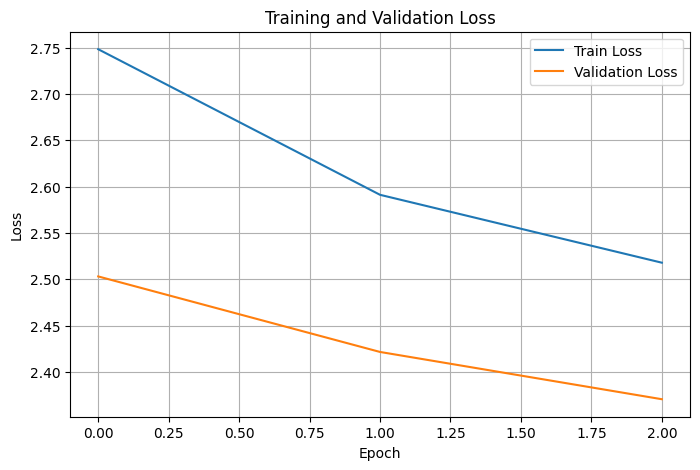

In [25]:
# Plot training and validation loss curves for each epoch
plt.figure(figsize=(8, 5))  # Set figure size

# Plot the recorded training and validation losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

# Add axis labels and a title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

# Show legend and grid for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [26]:
# Define a function to generate a response using Top-k sampling
def generate_response(input_text, k=50, max_length=64):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input message and move it to the correct device (CPU/GPU)
    input_ids = tokenizer.encode(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=64
    ).to(device)

    # Generate output token IDs using Top-k sampling
    output_ids = model.generate(
        input_ids,
        do_sample=True,              # Enable sampling instead of greedy decoding
        top_k=k,                     # Top-k sampling: randomly sample from top k tokens
        max_length=max_length,       # Max length of the generated output
        num_return_sequences=1,      # Generate one response
        eos_token_id=tokenizer.eos_token_id  # Stop generation at EOS token
    )

    # Decode the generated token IDs to string and skip special tokens
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Generate and display predictions for 5 random examples from the test set
print("Sample Predictions:\n")
for i in range(5):
    input_text = test_df.iloc[i]["message"]  # Get input message
    reference = test_df.iloc[i]["answer"].replace("<SOS> ", "").replace(" <EOS>", "")  # Clean reference answer
    generated = generate_response(input_text)  # Generate model response

    # Print input, reference, and generated output
    print(f"Input:      {input_text}")
    print(f"Reference:  {reference}")
    print(f"Generated:  {generated}")
    print("-" * 80)


Sample Predictions:

Input:       That is a good point, you are probably right.  Do you know that the instrument that makes all those metal sounding noises in horror movies is called?
Reference:  Yeah, I heard it was called a waterphone! Did you know that if you watch a horror film before viewing abstract are you actually enjoy the art more?
Generated:  SOS> I wonder if that sounds like the exact same as the name for that. EOS>
--------------------------------------------------------------------------------
Input:       When I lived in California a lot of people were catching on to using goats, too, and would rent them. I wonder if Google still lets you take your pet to work?
Reference:  That's hard to say. Did you know that a single Google search requires more computing power than it took to send Neil Armstrong and eleven other astronauts to the the moon?
Generated:  SOS> That is interesting. The internet is much better for mobile and web traffic. Have you heard of Google? EOS>
------